Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]
100%|██████████| 170M/170M [00:03<00:00, 46.8MB/s]



CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Extracting Features: 100%|██████████| 7/7 [00:00<00:00,  8.24it/s]


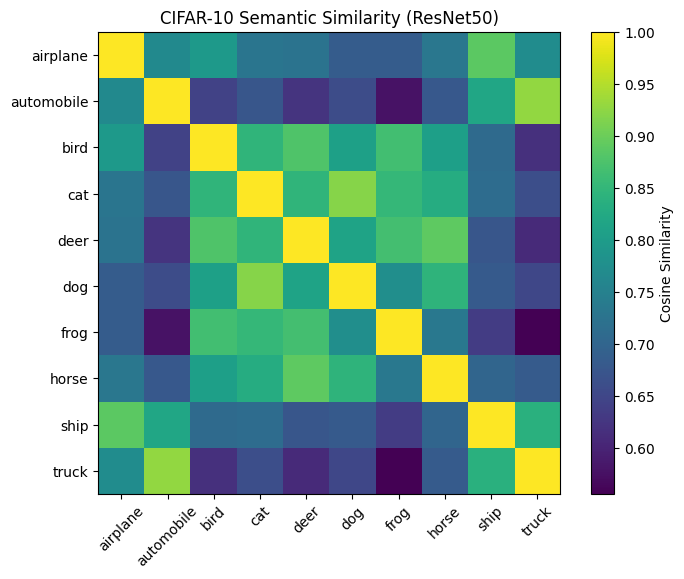

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/488 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/42.1M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/8.41M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Extracting Features: 100%|██████████| 16/16 [00:01<00:00, 10.76it/s]



🔹 CIFAKE Experiment Results:
Cosine Semantic Similarity: 0.9764
FID-like Semantic Distance: 57.66


/tmp/ipython-input-3338816635.py:60: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1.dot(sigma2))


In [ ]:

!pip install torch torchvision datasets scikit-learn matplotlib tqdm --quiet

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
from scipy.linalg import sqrtm
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.feature_extractor.eval()

    def forward(self, x):
        with torch.no_grad():
            x = self.feature_extractor(x)
        return x.view(x.size(0), -1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetFeatureExtractor().to(device)

def extract_features(dataloader, model, device):
    all_features, all_labels = [], []
    for imgs, labels in tqdm(dataloader, desc="Extracting Features"):
        imgs = imgs.to(device)
        feats = model(imgs)
        all_features.append(feats.cpu().numpy())
        all_labels.extend(labels)
    return np.concatenate(all_features), np.array(all_labels)


def cosine_dataset_similarity(features_A, features_B):
    mean_A = np.mean(features_A, axis=0)
    mean_B = np.mean(features_B, axis=0)
    return cosine_similarity([mean_A], [mean_B])[0][0]


def fid_like_score(features_A, features_B):
    mu1, sigma1 = np.mean(features_A, axis=0), np.cov(features_A, rowvar=False)
    mu2, sigma2 = np.mean(features_B, axis=0), np.cov(features_B, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)


def plot_heatmap(matrix, labels, title="Semantic Similarity Heatmap"):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap="viridis")
    plt.colorbar(label="Cosine Similarity")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.tight_layout()
    plt.show()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

cifar10 = datasets.CIFAR10(root="./data", download=True, train=True, transform=transform)
classes = cifar10.classes
print("\nCIFAR-10 Classes:", classes)

def get_class_subset(dataset, class_idx, n=200):
    """Randomly sample N images from a specific CIFAR-10 class."""
    indices = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    return Subset(dataset, random.sample(indices, n))

class_features = {}
for i, cls in enumerate(classes):
    subset = get_class_subset(cifar10, i)
    loader = DataLoader(subset, batch_size=32, shuffle=False)
    feats, _ = extract_features(loader, model, device)
    class_features[cls] = feats

sim_matrix = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        sim_matrix[i, j] = cosine_dataset_similarity(class_features[classes[i]],
                                                     class_features[classes[j]])

plot_heatmap(sim_matrix, classes, title="CIFAR-10 Semantic Similarity (ResNet50 Features)")


cifake = load_dataset("dragonintelligence/CIFAKE-image-dataset")

def preprocess_hf(dataset, label_int, n=500):
    """Convert HuggingFace dataset entries into torch tensors."""
    samples = [x for x in dataset["train"] if x["label"] == label_int][:n]
    if not samples:
        raise ValueError(f"No images found for label {label_int}")
    tensors = [transform(x["image"]) for x in samples]
    labels = torch.zeros(len(tensors))
    return list(zip(tensors, labels))

def make_loader(subset, batch_size=32):
    """Create DataLoader from preprocessed images."""
    imgs, lbls = zip(*subset)
    return DataLoader(list(zip(imgs, lbls)), batch_size=batch_size, shuffle=False)

real_subset = preprocess_hf(cifake, 0, n=500)
fake_subset = preprocess_hf(cifake, 1, n=500)

real_loader = make_loader(real_subset)
fake_loader = make_loader(fake_subset)

real_feats, _ = extract_features(real_loader, model, device)
fake_feats, _ = extract_features(fake_loader, model, device)

cos_sim = cosine_dataset_similarity(real_feats, fake_feats)
fid_score = fid_like_score(real_feats, fake_feats)

print("\n CIFAKE Dataset Comparison Results:")
print(f"Cosine Semantic Similarity: {cos_sim:.4f}")
print(f"FID-like Semantic Distance: {fid_score:.2f}")
